In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt


# Frailty Index Model

# $\frac{df}{dt} = a \cdot (1-f)   \cdot (1+bt) - fr(1-st)$


# Mortality Models

# $\mu = f(t)^c$

# $\mu = \mu_0 e^{d\cdot f}$

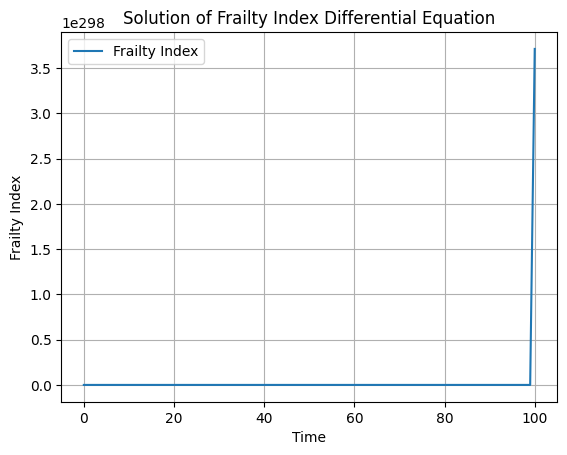

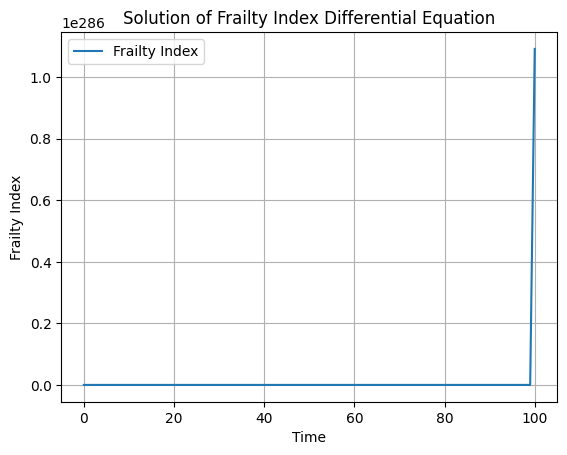

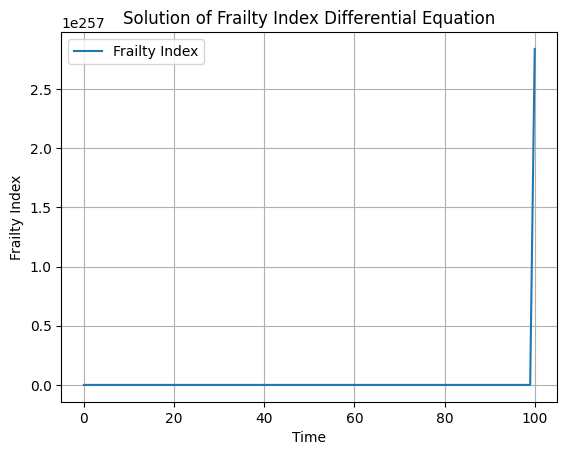

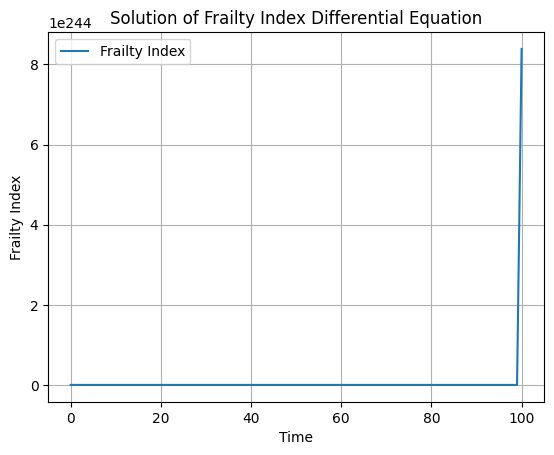

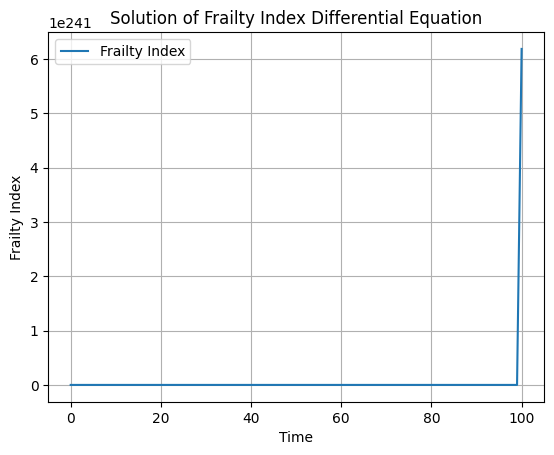

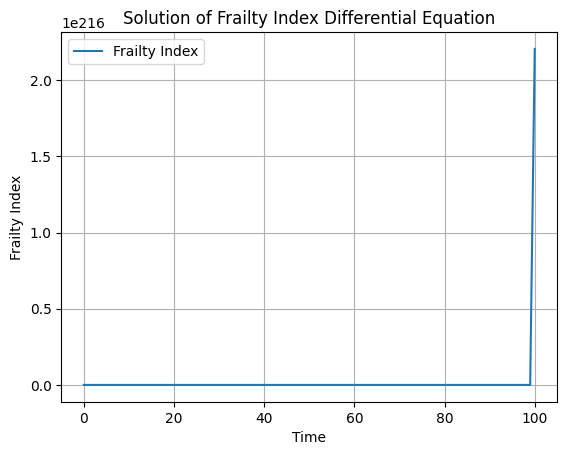

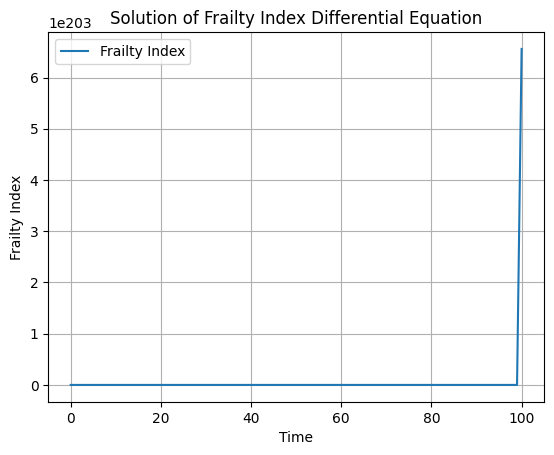

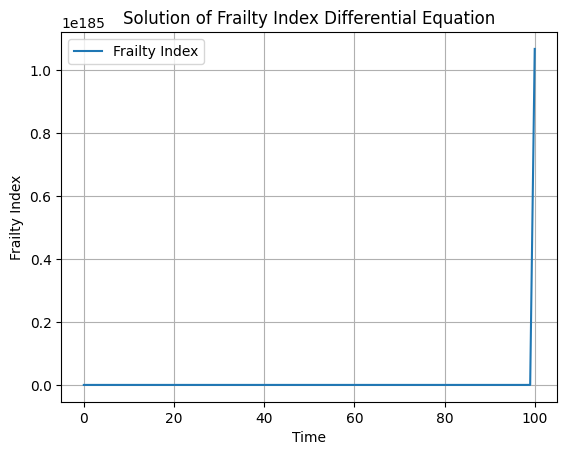

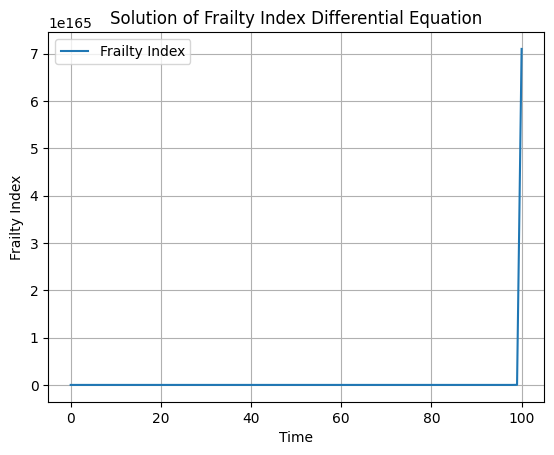

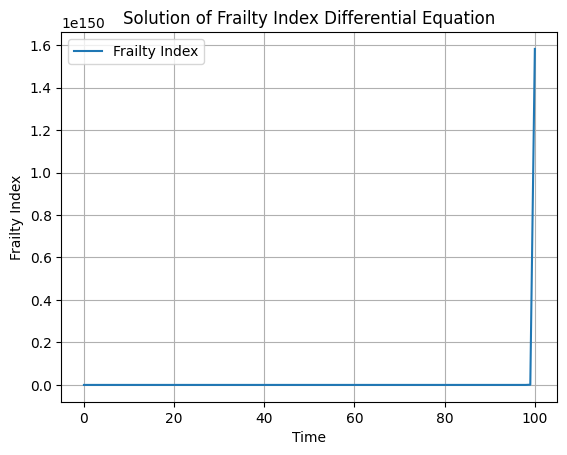

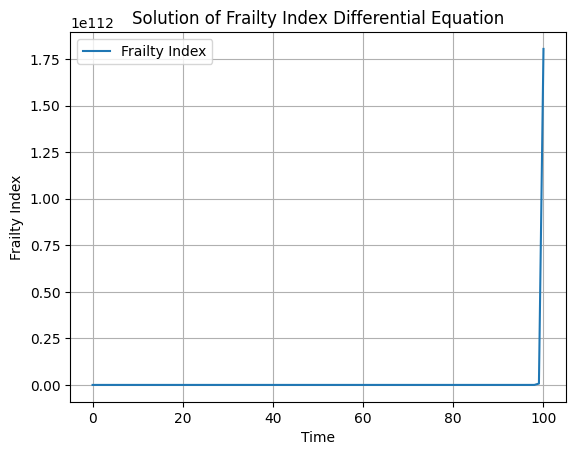

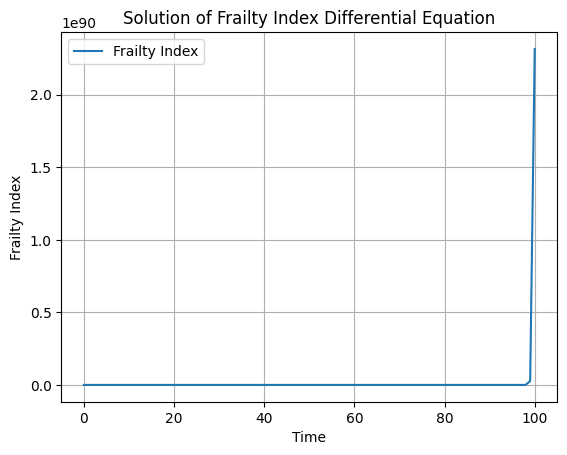

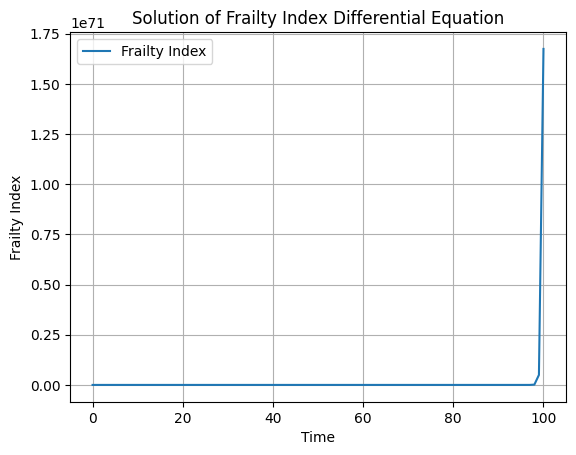

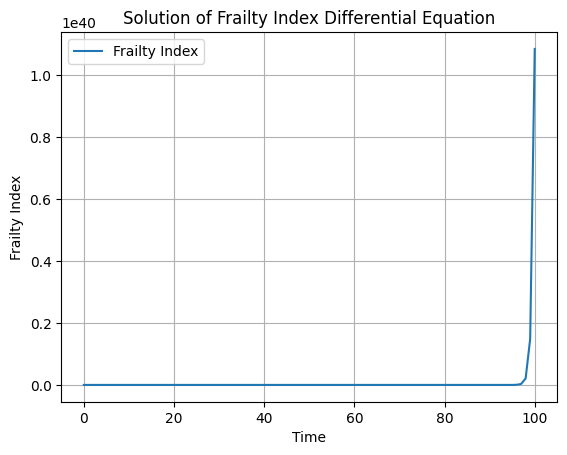

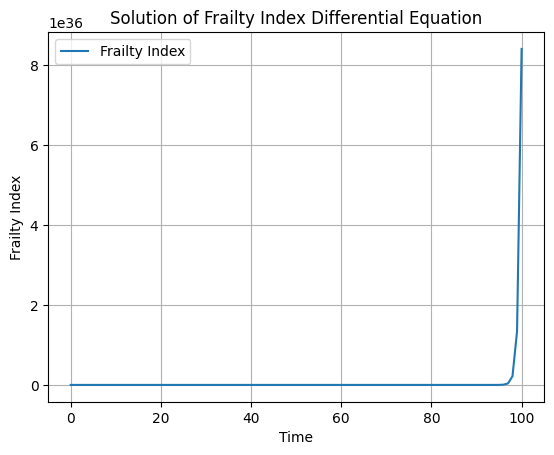

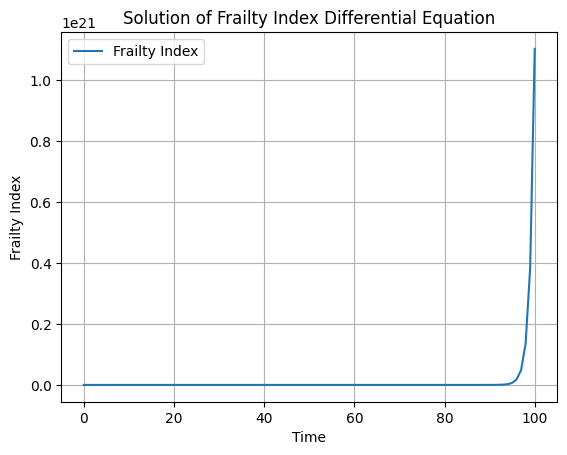

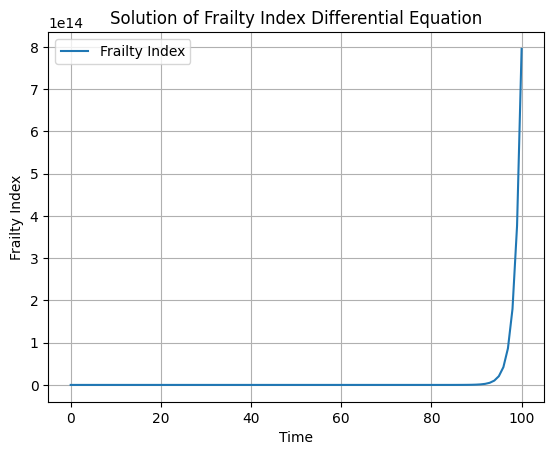

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    #dfdt = (1 - f)*(a*f + b) 
    return dfdt

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.5
r = 0.8
s = 0.2

# Time points
t = np.linspace(0, 100, 100)  # 100 time steps from 0 to 10

# Function to update the plot
def update_plot(a, b, r, s, initial_condition):
    f_solution = odeint(frailty_index_differential_equation, initial_condition, t, args=(a, b, r, s))

    plt.figure()  # Set the current figure
    plt.clf()  # Clear the previous plot

    plt.plot(t, f_solution, label='Frailty Index')
    plt.xlabel('Time')
    plt.ylabel('Frailty Index')
    plt.title('Solution of Frailty Index Differential Equation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create sliders for interactive parameter adjustment
slider_a = widgets.FloatSlider(value=a, min=0.0, max=1.0, step=0.001, description='a:')
slider_b = widgets.FloatSlider(value=b, min=0, max=2, step=0.001, description='b:')
slider_r = widgets.FloatSlider(value=r, min=0, max=1, step=0.001, description='r:')
slider_s = widgets.FloatSlider(value=s, min=0, max=1, step=0.001, description='s:')
slider_initial_condition = widgets.FloatSlider(value=f0, min=0, max=1, step=0.1, description='Initial Condition:')

# Define the function to be called when sliders are changed
def on_value_change(change):
    a = slider_a.value
    b = slider_b.value
    r = slider_r.value
    s = slider_s.value
    initial_condition = slider_initial_condition.value
    update_plot(a, b, r, s, initial_condition)

# Attach the function to the slider value change event
slider_a.observe(on_value_change, names='value')
slider_b.observe(on_value_change, names='value')
slider_r.observe(on_value_change, names='value')
slider_s.observe(on_value_change, names='value')
slider_initial_condition.observe(on_value_change, names='value')

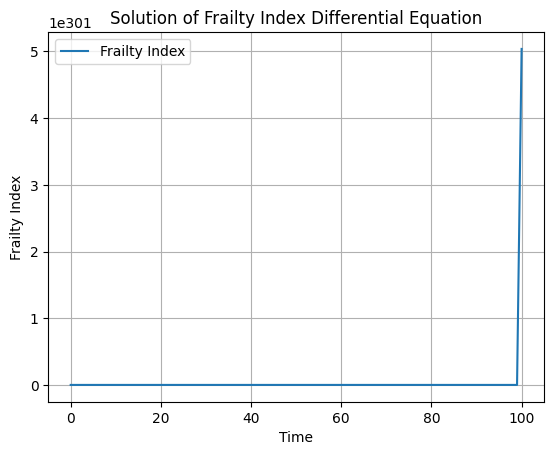

In [25]:
# Display the interactive plot and sliders
display(widgets.VBox([slider_a, slider_b, slider_r, slider_s, slider_initial_condition]))

update_plot(a, b, r, s, f0)  # Display the initial plot

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    return dfdt

# Initial conditions
f0 = 0.1  # Initial frailty index
a = 0.01
b = 0.59
r = 0.04
s = 0.16

# Time points
t = np.linspace(0, 100, 100)  # 100 time steps from 0 to 10

# Solving the differential equation
f_solution = odeint(frailty_index_differential_equation, f0, t, args=(a, b, r, s))

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(t, f_solution, label='Frailty Index')
plt.xlabel('Time')
plt.ylabel('Frailty Index')
plt.title('Solution of Frailty Index Differential Equation')
plt.legend()
plt.grid(True)


In [ ]:
c = 1.98
frailty_index = []
for i in f_solution:
    frailty_index.append(i[0])
frailty_index = np.array(frailty_index)
gompertz_law_differential_equation = frailty_index**c
plt.scatter(t[50:85], gompertz_law_differential_equation[50:85])
plt.yscale("log")

In [ ]:


parametro_beta = []
parametro_R = []



data = gompertz_law_differential_equation[50:75]
derivative_process = dxdt(data, t[50:75], kind="finite_difference", k=1)

beta_values = derivative_process/data
R_values = data/np.e**(beta_values*t[50:75])

parametro_R.append(R_values)
parametro_beta.append(beta_values)
plt.scatter(parametro_beta, parametro_R)
plt.yscale("log")